In [1]:
from pyiron_workflow_vasp.vasp import vasp_job, VaspInput
from pymatgen.io.vasp.inputs import Incar
from pymatgen.io.ase import AseAtomsAdaptor
#from vasp_node_job import get_default_POTCAR_paths, write_POTCAR
import numpy as np
from ase.build import bulk

%load_ext autoreload
%autoreload 2

/cmmc/ptmp/hmai/mambaforge/envs/pyiron_workflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running a single calculation on the login node

In [2]:
from pyiron_vasp.vasp.output import parse_vasp_output
parse_vasp_output?

Signature:
parse_vasp_output(
    working_directory: str,
    structure: pyiron_atomistics.atomistics.structure.atoms.Atoms = None,
    sorted_indices: list = None,
) -> dict
Docstring:
Parse the VASP output in the working_directory and return it as hierachical dictionary.

Args:
    working_directory (str): directory of the VASP calculation
    structure (Atoms): atomistic structure as optional input for matching the output to the input of the calculation
    sorted_indices (list): list of indices used to sort the atomistic structure

Returns:
    dict: hierarchical output dictionary
File:      /cmmc/ptmp/hmai/mambaforge/envs/pyiron_workflow/lib/python3.12/site-packages/pyiron_atomistics/vasp/output.py
Type:      function

In [3]:
# Create the incar input for our job
incar = Incar.from_dict({
    "ENCUT": 520,
    "EDIFF": 1e-4,
    "ISMEAR": 1,
    "SIGMA": 0.1,
    "ISPIN": 2,
    "MAGMOM": "2*3.0"
})
# Create an iron bcc structure with lattice param 2.83
bulk_Fe = bulk("Fe", cubic=True, a=2.83)
vi = VaspInput(bulk_Fe, incar)
# Instantiate our node 
v_job = vasp_job(workdir="/cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/test",
                 vasp_input = vi)
# 
output = v_job.run(run_data_tree=True)
#print(v_job.outputs.to_value_dict()["vasp_output"]["generic"]["energy_pot"])

/cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/pyiron_workflow_vasp/vasp.py:227: UserWarning: Directory '/cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/test' already exists. Existing files may be overwritten.
  warnings.warn(


In [4]:
v_job.outputs.convergence_status.value

True

In [42]:
v_job.outputs.vasp_output.value

{'description': 'This contains all the output static from this particular vasp run',
 'generic': {'temperature': array([0.]),
  'stresses': array([[[-0.0094183,  0.       , -0.       ],
          [ 0.       , -0.0094183,  0.       ],
          [-0.       ,  0.       , -0.0094183]]]),
  'pressures': array([[-0.00313943, -0.00313943, -0.00313943]]),
  'elastic_constants': None,
  'forces': array([[[ 0.,  0.,  0.],
          [-0., -0., -0.]]]),
  'cells': array([[[2.83, 0.  , 0.  ],
          [0.  , 2.83, 0.  ],
          [0.  , 0.  , 2.83]]]),
  'volume': array([22.665187]),
  'energy_pot': array([-16.49966517]),
  'energy_tot': array([-16.49966517]),
  'steps': array([0]),
  'positions': array([[[0.   , 0.   , 0.   ],
          [1.415, 1.415, 1.415]]]),
  'dft': {'n_elect': 16.0,
   'magnetization': [[4.2205239, 4.2205239]],
   'final_magmoms': [],
   'e_fermi_list': array([5.7361]),
   'vbm_list': array([[5.9987],
          [5.7213]]),
   'cbm_list': array([[6.15  ],
          [6.1266]

In [6]:
v_job.outputs.to_value_dict()["vasp_output"]["generic"]["energy_pot"]

array([-16.49966517])

In [7]:
v_job.outputs.to_value_dict()["vasp_output"]["generic"]["forces"]

array([[[ 0.,  0.,  0.],
        [-0., -0., -0.]]])

# Running a job in the queue

In [8]:
from pyiron_workflow_vasp.generic import submit_to_slurm

submit_to_slurm?

Signature:
submit_to_slurm(
    node,
    /,
    job_name=None,
    output_file=None,
    error_file=None,
    time_limit='00:05:00',
    account='hmai',
    partition='s.cmmg',
    nodes=1,
    ntasks=1,
    cpus_per_task=1,
    memory='1GB',
)
Docstring:
An example of a helper function for running nodes on slurm.

- Saves the node
- Writes a slurm batch script that 
    - Loads the node
    - Runs it
    - Saves it again
- Runs the batch script
File:      /cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/pyiron_workflow_vasp/generic.py
Type:      function

In [17]:
import pyiron_workflow as pwf
from time import sleep, perf_counter
ntasks = 1
wf = pwf.Workflow("vasp_job_queue_cmfe")
# Remove the job if we had run it before for the sake of demonstration
try:
    wf.remove_child(wf.vasp_job)
    wf.failed = False
except:
    pass
wf.vasp_job = vasp_job(workdir="/cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/test_queue_cmfe",
                    vasp_input = vi,
                    command = f"module load vasp; module load intel/19.1.0 impi/2019.6; unset I_MPI_HYDRA_BOOTSTRAP; unset I_MPI_PMI_LIBRARY; srun -c 1 -n {ntasks} --hint=nomultithread vasp_std")

# "Checkpoint" the vasp_job step so that the workflow saves the results whenever it finishes vasp_job
wf.vasp_job.checkpoint = "pickle"

# submit the workflow to slurm.
submit_to_slurm(wf,
                job_name="test_queue_cmfe",
                output_file=None,
                error_file=None,
                time_limit='00:05:00',
                partition='s.cmfe',
                nodes=1,
                ntasks=ntasks,
                cpus_per_task=1,
                memory='1GB',)

### Just to demonstrate we are actually in queue
while not wf.has_saved_content():
    sleep(0.2)
reloaded = pwf.Workflow(wf.label)
    
while reloaded.vasp_job.outputs.vasp_output.value is pwf.NOT_DATA:
    reloaded.load()
    print(reloaded.vasp_job.outputs.convergence_status, reloaded.vasp_job.outputs.vasp_output)
    sleep(60)

Submitted batch job 15070151
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA


KeyboardInterrupt: 

In [47]:
print(reloaded.vasp_job.outputs.convergence_status, reloaded.vasp_job.outputs.vasp_output)

NOT_DATA NOT_DATA


### What if I want to use a different pseudopotential? - i.e. the Fe_sv pseudopotential?

In [19]:
# Same as before
incar = Incar.from_dict({
    "ENCUT": 520,
    "EDIFF": 1e-4,
    "ISMEAR": 1,
    "SIGMA": 0.1,
    "ISPIN": 2,
    "MAGMOM": "2*3.0"
})

bulk_Fe = bulk("Fe", cubic=True, a=2.83)
# Simply change the potcar_paths value. 
# This doesn't come with batteries included (for now) with automatic per-element mapping
# - you will have to generate the list of paths for the entire structure in order. 
vi_Fe_sv = VaspInput(structure = bulk_Fe,
               incar = incar,
               potcar_paths = ["/cmmc/u/hmai/vasp_potentials_54/Fe_sv/POTCAR"])
v_job_Fe_sv = vasp_job(workdir="/cmmc/u/hmai/github_dev_pyiron_from_backup_20241124/pyiron_workflow_vasp/test_Fe_sv",
                 vasp_input = vi_Fe_sv)
output_Fe_sv = v_job_Fe_sv.run()

In [20]:
output_Fe_sv

{'vasp_output': {'description': 'This contains all the output static from this particular vasp run',
  'generic': {'temperature': array([0.]),
   'stresses': array([[[-0.03595592,  0.        , -0.        ],
           [ 0.        , -0.03595592, -0.        ],
           [-0.        , -0.        , -0.03595592]]]),
   'pressures': array([[-0.01198531, -0.01198531, -0.01198531]]),
   'elastic_constants': None,
   'forces': array([[[ 0., -0.,  0.],
           [-0.,  0., -0.]]]),
   'cells': array([[[2.83, 0.  , 0.  ],
           [0.  , 2.83, 0.  ],
           [0.  , 0.  , 2.83]]]),
   'volume': array([22.665187]),
   'energy_pot': array([-16.71785025]),
   'energy_tot': array([-16.71785025]),
   'steps': array([0]),
   'positions': array([[[0.   , 0.   , 0.   ],
           [1.415, 1.415, 1.415]]]),
   'dft': {'n_elect': 32.0,
    'magnetization': [[6.0,
      6.0,
      6.0,
      6.0,
      3.7153814,
      4.3436811,
      4.22745,
      4.1670966,
      4.1952615,
      4.1894165,
      

### What is the advantage of this over traditional pyiron? We can do all this currently!

### You can now use these as "building blocks" for larger workflows and submit each workflow to the cluster!

# A basic example with equations of state calculations -
### Looping over strains to generate energy-volume curves

In [26]:
from pyiron_workflow import for_node

@pwf.as_function_node("structure_list", "directories", "vasp_inputs")
def generate_calc_inputs(base_structure, incar, workdir=".", num_points=11, strains=(-0.2, 0.2), potcar_paths=None):
    # Generate strained structures
    structure_list = []
    for strain in np.linspace(strains[0], strains[1], num_points):
        structure = base_structure.copy()
        structure.apply_strain(strain)
        structure_list.append(structure)
    
    # Generate directory names
    directories = [f"{workdir}/vasp_run_{i}" for i in np.round(np.linspace(strains[0], strains[1], num_points), 3)]
    
    # Generate VASP inputs
    vasp_inputs = [VaspInput(structure, incar, potcar_paths=potcar_paths) for structure in structure_list]
    
    return structure_list, directories, vasp_inputs

@pwf.as_function_node("structure_list", "directories", "vasp_inputs")
def generate_calc_inputs(base_structure, incar, workdir=".", num_points=11, strains=(-0.2, 0.2), potcar_paths=None):
    import numpy as np

    # Generate strained structures for ASE Atoms objects using isotropic scaling.
    structure_list = []
    for strain in np.linspace(strains[0], strains[1], num_points):
        # Copy the base structure (an ASE Atoms instance)
        structure = base_structure.copy()
        
        # Retrieve the current cell
        cell = structure.get_cell()
        
        # Apply an isotropic strain by scaling the cell uniformly.
        # Here, each element of the cell matrix is scaled by (1 + strain).
        new_cell = cell * (1 + strain)
        
        # Update the cell and scale the atomic positions accordingly.
        structure.set_cell(new_cell, scale_atoms=True)
        
        structure_list.append(structure)
    
    # Generate directory names based on the strain values.
    directories = [f"{workdir}/vasp_run_{i}" for i in np.round(np.linspace(strains[0], strains[1], num_points), 3)]
    
    # Create VASP input objects from the strained structures.
    vasp_inputs = [VaspInput(structure, incar, potcar_paths=potcar_paths) for structure in structure_list]
    
    return structure_list, directories, vasp_inputs
    
@pwf.as_function_node("v0", "e0", "B")
def equation_of_state(volumes, energies, eos="sj"):
    from ase.eos import EquationOfState
    eos = EquationOfState(volumes, energies, eos=eos)
    v0, e0, B = eos.fit() #v0, e0, B
    return v0, e0, B#eos_results

@pwf.as_function_node()
def extract_volumes(vasp_fornode_df):
    volumes = [item["generic"]["volume"][-1] for item in vasp_fornode_df.tolist()]
    return volumes
    
@pwf.as_function_node()
def extract_energies(vasp_fornode_df):
    energies = [item["generic"]["energy_pot"][-1] for item in vasp_fornode_df.tolist()]
    return energies
    
@pwf.as_macro_node("v0", "e0", "B", "volumes", "energies")
def volume_scan(wf,
                base_structure,
                incar,
                potcar_paths=None,
                workdir=".",
                num_points=11,
                strains=(-0.1, 0.1),
                pseudo_set="PBE.54"):

    wf.calc_inputs = generate_calc_inputs(base_structure, incar, workdir, num_points, strains, potcar_paths)
    wf.volume_scan_forloop = for_node(
        vasp_job,
        zip_on=("vasp_input", "workdir"),
        vasp_input=wf.calc_inputs.outputs.vasp_inputs,
        workdir=wf.calc_inputs.outputs.directories,
    )
    # This step is just really unwieldy and unpleasant - why is extracting data output from a fornode require a node itself?
    wf.volumes = extract_volumes(wf.volume_scan_forloop.outputs.df.vasp_output)
    wf.energies = extract_energies(wf.volume_scan_forloop.outputs.df.vasp_output)
    wf.eos_outputs = equation_of_state(wf.volumes, wf.energies)
    #wf.v0, wf.e0, wf.B = equation_of_state(wf.volume_scan.outputs.df.apply(lambda x: x["generic"]["energy_pot"][-1]), 
     #                                        wf.volume_scan.outputs.df.apply(lambda x: x["generic"]["volume"][-1]))#, wf.volume_scan.outputs.
    return wf.eos_outputs.outputs.v0, wf.eos_outputs.outputs.e0, wf.eos_outputs.outputs.B, wf.volumes, wf.energies

In [27]:
incar = Incar.from_dict( {
"ALGO": "Fast",
"AMIX": 0.01,
"AMIX_MAG": 0.1,
"BMIX": 0.0001,
"BMIX_MAG": 0.0001,
"EDIFF": 1e-05,
"EDIFFG": 1e-05,
"ENCUT": 500,
"GGA": "Pe",
"IBRION": 2,
"ISIF": 2,
"ISMEAR": 1,
"ISPIN": 2,
"ISTART": 0,
"KPAR": 1,
"LORBIT": 10,
"LPLANE": False,
"LREAL": False,
"MAGMOM": "2*3.0", # Keep as string because it's a special format in VASP
"NCORE": 1,
"NELM": 300,
"NSIM": 1,
"NSW": 0,
"PREC": "Accurate",
"SIGMA": 0.2,
})
# strained_structures, dirnames, vasp_inputs = generate_calc_inputs(bulk_Fe, incar=incar, workdir="scan_volumes_Fe", num_points=11, strains=(-0.2, 0.2), potcar_paths=["/cmmc/u/hmai/vasp_potentials_54/Fe/POTCAR"])()
results_Fe_sv = volume_scan(bulk_Fe, incar, workdir="scan_volumes_Fe_sv", potcar_paths=["/cmmc/u/hmai/vasp_potentials_54/Fe_sv/POTCAR"], num_points=8, strains=(-0.16, 0.08))()
results_Fe = volume_scan(bulk_Fe, incar, workdir="scan_volumes_Fe", potcar_paths=["/cmmc/u/hmai/vasp_potentials_54/Fe/POTCAR"], num_points=8, strains=(-0.16, 0.08))()
results_Fe_pv = volume_scan(bulk_Fe, incar, workdir="scan_volumes_Fe_pv", potcar_paths=["/cmmc/u/hmai/vasp_potentials_54/Fe_pv/POTCAR"], num_points=8, strains=(-0.16, 0.08))()

# print(results_Fe, results_Fe["v0"]**(1/3))

In [46]:
results_Fe_sv

{'v0': 22.965345830590508,
 'e0': -16.724376492524136,
 'B': 1.1973137336236752,
 'volumes': [13.433746995648006,
  15.146749820508692,
  16.999515038836343,
  18.997523528728603,
  21.146256397691996,
  23.451194081387705,
  25.91781767150582,
  28.551608046144004],
 'energies': [-10.71456157,
  -13.34851133,
  -15.16085835,
  -16.1881153,
  -16.65246046,
  -16.68819616,
  -16.49468183,
  -16.21155152],
 'relative_energy': array([5.97363459, 3.33968483, 1.52733781, 0.50008086, 0.0357357 ,
        0.        , 0.19351433, 0.47664464])}

In [36]:
results_Fe_sv["v0"]**(1/3)

2.8424379742618133

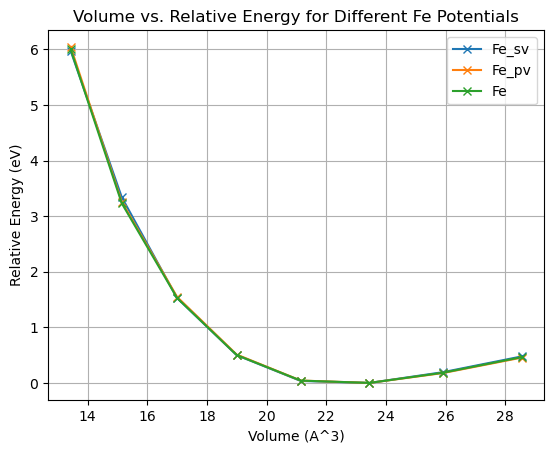

In [29]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["Fe_sv", "Fe_pv", "Fe"]
strains = (-0.1, 0.1)
num_points = 11

for i, df in enumerate([results_Fe_sv, results_Fe_pv, results_Fe]):
    # Find the minimum energy in the current dataframe
    min_energy = min(df["energies"])
    
    # Subtract the minimum energy from each energy value to zero the minimum
    df["relative_energy"] = df["energies"] - min_energy
    
    # Plot relative energy vs. volume
    plt.plot(df["volumes"], df["relative_energy"], marker="x", label=labels[i])

plt.grid()
plt.legend()
plt.xlabel('Volume (A^3)')
plt.ylabel('Relative Energy (eV)')
plt.title('Volume vs. Relative Energy for Different Fe Potentials')
plt.show()


### Great - but I could still do this in old pyiron with Master jobs - show me something I can't do
#### Let's do a single workflow for finding the lattice parameter, using that lattice parameter to build a cell, then finding the grain boundary energy of a twin after cell-length relaxation.

In [38]:
@pwf.as_function_node("a0")
def get_a0(volumes, energies, eos="sj"):
    from ase.eos import EquationOfState
    eos = EquationOfState(volumes, energies, eos=eos)
    v0, e0, B = eos.fit() #v0, e0, B
    return v0**1/3

In [ ]:
wf_2 = pwf.Workflow("equilibrium_lat_to_gbenergy")
# Remove the job if we had run it before for the sake of demonstration
try:
    wf_2.remove_child(wf_2.vasp_job)
    wf_2.failed = False
except:
    pass
wf_2.volume_scan = volume_scan(bulk_Fe,
                               incar,
                               workdir="scan_volumes_Fe_sv",
                               potcar_paths=["/cmmc/u/hmai/vasp_potentials_54/Fe_sv/POTCAR"],
                               num_points=8,
                               strains=(-0.16, 0.08))
wf_2.a0 = get_a0(volumes = wf_2.volume_scan.outputs.volumes,
                 energies = wf_2.volume_scan.outputs.energies)

wf_2.starter_gb_struct = build_gb(wf_2.outputs.a0,
                                 )
wf_2.strained_gbs = strain_structure(wf_2.starter_gb_struct, distance = np.linspace([0.0]))

wf_2.calc_inputs = generate_calc_inputs(base_structure, incar, workdir, num_points, strains, potcar_paths)
wf_2.volume_scan_forloop = for_node(
    vasp_job,
    zip_on=("vasp_input", "workdir", "command"),
    vasp_input=wf.calc_inputs.outputs.vasp_inputs,
    workdir=wf.calc_inputs.outputs.directories,
    command=f"module load vasp;
    module load intel/19.1.0 impi/2019.6;
    unset I_MPI_HYDRA_BOOTSTRAP;
    unset I_MPI_PMI_LIBRARY;
    srun -c 1 -n {ntasks} --hint=nomultithread vasp_std"
)

wf_2.volume_scan_forloop.checkpoint = "pickle"


submit_to_slurm(wf_2,
                job_name="test_queue_cmfe",
                output_file=None,
                error_file=None,
                time_limit='00:05:00',
                partition='s.cmfe',
                nodes=1,
                ntasks=ntasks,
                cpus_per_task=1,
                memory='1GB',)

reloaded = pwf.Workflow(wf_equillat_to_gb.label)

while reloaded.vasp_job.outputs.vasp_output.value is pwf.NOT_DATA:
    reloaded.load()
    print(reloaded.vasp_job.outputs.convergence_status, reloaded.vasp_job.outputs.vasp_output)
    sleep(60)